In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("TPML") \
    .config("spark.some.config.option","some-value") \
    .getOrCreate()

df = spark.read.csv("tweet_sentiment.csv", header=True, inferSchema=True)
df.show()


23/04/05 22:24:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+--------------------+---------+
|      cleaned_tweets|sentiment|
+--------------------+---------+
|video offic mind ...|        0|
|price lumber lb f...|        0|
|say american drea...|       -1|
|barri silbert ext...|        1|
|satellit avoid at...|       -1|
|david butler favo...|        0|
|miss convo one fa...|        0|
|u intellig docume...|        0|
|senat want emerg ...|        1|
|hedg fund manag m...|        0|
|u propos expedit ...|       -1|
|roger feder uniql...|        0|
|bond trader ahead...|        0|
|alcoa cut adjust ...|        0|
|custom urg boycot...|       -1|
|gap tighten race ...|        0|
|presid trump endo...|        0|
|white hous strugg...|        0|
|laker guard hart ...|        0|
|two northern whit...|        0|
+--------------------+---------+
only showing top 20 rows



In [2]:
from pyspark.sql.functions import col, lower, count, regexp_replace, udf
from pyspark.sql.types import StringType, ArrayType
import matplotlib.pyplot as plt
import seaborn as sns
import string


In [3]:
#show data size
print("Row count:", df.count())
print("Col count:", len(df.columns))


Row count: 28440
Col count: 2


In [4]:
# Supprimer les enregistrements en double
df = df.dropDuplicates()
# Supprimer les enregistrements avec des valeurs manquantes
df = df.dropna()

In [5]:
#show data size
print("Row count:", df.count())
print("Col count:", len(df.columns))

Row count: 21994
Col count: 2


In [6]:
df = df.filter(df.sentiment != 0)

In [7]:
df.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|       -1| 2114|
|        1| 6752|
+---------+-----+



In [8]:
from pyspark.sql.functions import when

df = df.withColumn("sentiment", when(df.sentiment == -1, 0).otherwise(df.sentiment))


<AxesSubplot: xlabel='sentiment', ylabel='count'>

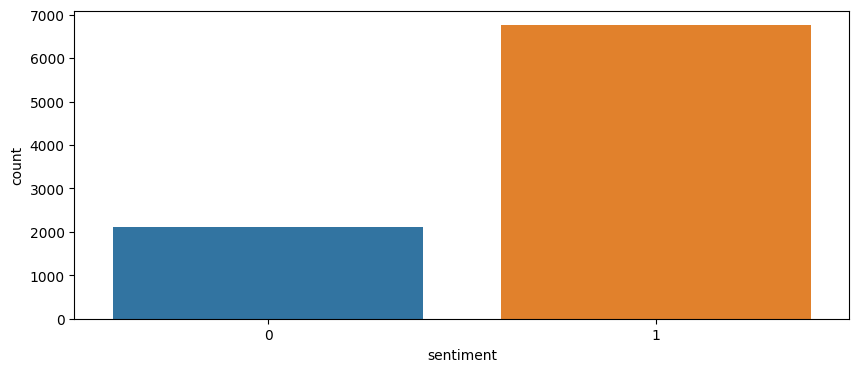

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Tracer un graphique à barres de la colonne "sentiment"
sentiment_counts = df.groupBy("sentiment").count().toPandas()
plt.figure(figsize=(10,4))
sns.barplot(data=sentiment_counts, x="sentiment", y="count")

In [10]:
# Convertir les tweets en minuscules
df = df.withColumn("cleaned_tweets", lower(col("cleaned_tweets")))

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
# Supprimer la ponctuation des tweets
def remove_punch(txt):
    txt_punch_removed = [char for char in txt if char not in string.punctuation ]
    return ''.join(txt_punch_removed)

remove_punch_udf = udf(remove_punch, StringType())

df = df.withColumn("cleaned_tweets1", remove_punch_udf(col("cleaned_tweets")))
df.select(col("cleaned_tweets1")).show(truncate=False)

+-------------------------------------------------------------------------------------------------+
|cleaned_tweets1                                                                                  |
+-------------------------------------------------------------------------------------------------+
|qorvo plan debt offer qrvo                                                                       |
|expeditor intl wash inc expd valuat rose cwm llc cut hold million                                |
|bwa ten sea fli one arc low                                                                      |
|intern paper ip cut hold zack invest research                                                    |
|short sale volum short interest xli bac nfx trq bbd                                              |
|haverford trust compani boost hold air product amp chemic inc apd million                        |
|intu max pain matur maxpain option                                                               |


In [13]:
from pyspark.ml.feature import Tokenizer
tokenizer0 = Tokenizer(inputCol="cleaned_tweets1", outputCol="token_tweet")
df = tokenizer0.transform(df)

In [14]:
df.select(col("token_tweet")).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|token_tweet                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------+
|[qorvo, plan, debt, offer, qrvo]                                                                                       |
|[expeditor, intl, wash, inc, expd, valuat, rose, cwm, llc, cut, hold, million]                                         |
|[bwa, ten, sea, fli, one, arc, low]                                                                                    |
|[intern, paper, ip, cut, hold, zack, invest, research]                                                                 |
|[short, sale, volum, short, interest, xli, bac, nfx, trq, bbd]                                                         |
|[haverford, trust, comp

In [15]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="token_tweet", outputCol="mots_propres")
df = remover.transform(df)


In [16]:
df.select(col("mots_propres")).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|mots_propres                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------+
|[qorvo, plan, debt, offer, qrvo]                                                                                       |
|[expeditor, intl, wash, inc, expd, valuat, rose, cwm, llc, cut, hold, million]                                         |
|[bwa, ten, sea, fli, one, arc, low]                                                                                    |
|[intern, paper, ip, cut, hold, zack, invest, research]                                                                 |
|[short, sale, volum, short, interest, xli, bac, nfx, trq, bbd]                                                         |
|[haverford, trust, comp

In [17]:
from pyspark.ml.feature import NGram
# Utilisation de la fonction NGram pour créer des n-grams de taille 2 à partir de la colonne "tokens"
ngram = NGram(n=2, inputCol="token_tweet", outputCol="ngram_tweet")
df = ngram.transform(df)
df.select(col("ngram_tweet")).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ngram_tweet                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[qorvo plan, plan debt, debt offer, offer qrvo]                                                                                                                                                                    |
|[expeditor intl, intl wash, wash inc, inc expd, expd valuat, valuat rose, rose cwm, cwm llc, llc cut, cut hold, hold million]                  

In [18]:
from pyspark.ml.feature import HashingTF
# représenter des données textuelles sous forme numérique afin utilisée comme entrée pour les modèles de classification et d'apprentissage automatique.
hashingTF = HashingTF(numFeatures=1000, inputCol="ngram_tweet", outputCol="hashing_tweet")
df = hashingTF.transform(df)
df.select(col("hashing_tweet")).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|hashing_tweet                                                                                                                                                             |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(1000,[36,240,316,848],[1.0,1.0,1.0,1.0])                                                                                                                                 |
|(1000,[5,238,295,504,545,609,705,758,824,831,971],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                                                          |
|(1000,[106,120,366,429,577,651],[1.0,1.0,1.0,1.0,1.0,1.0])                                                                            

In [20]:
from pyspark.ml.feature import IDF
#évaluer l'importance d'un terme dans un documents afin d'attribuer un poids plus élevé aux termes qui apparaissent rarement dans un corpus et un poids plus faible aux termes qui apparaissent fréquemment.
idf2 = IDF(inputCol="hashing_tweet", outputCol="idf_tweet")
idf_model = idf2.fit(df)
df = idf_model.transform(df)
df.select(col("idf_tweet")).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|idf_tweet                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------

In [21]:
df2 = spark.read.csv("tweet.csv", header=True, inferSchema=True)
df2.show()

+--------------------+---------+
|      cleaned_tweets|sentiment|
+--------------------+---------+
|video offic mind ...|        0|
|price lumber lb f...|        0|
|say american drea...|       -1|
|barri silbert ext...|        1|
|satellit avoid at...|       -1|
|david butler favo...|        0|
|miss convo one fa...|        0|
|u intellig docume...|        0|
|senat want emerg ...|        1|
|hedg fund manag m...|        0|
|u propos expedit ...|       -1|
|roger feder uniql...|        0|
|bond trader ahead...|        0|
|alcoa cut adjust ...|        0|
|custom urg boycot...|       -1|
|gap tighten race ...|        0|
|presid trump endo...|        0|
|white hous strugg...|        0|
|laker guard hart ...|        0|
|two northern whit...|        0|
+--------------------+---------+
only showing top 20 rows



In [22]:
# Supprimer les enregistrements en double
df2 = df2.dropDuplicates()
df2 = df2.na.drop()

In [23]:
df2 = df2.filter(df2.sentiment != 0)

In [24]:
from pyspark.sql.functions import when

df2 = df2.withColumn("sentiment", when(df2.sentiment == -1, 0).otherwise(df2.sentiment))


In [25]:
df2.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|        1| 6752|
|        0| 2114|
+---------+-----+



In [26]:
# Convertir les tweets en minuscules
df2 = df2.withColumn("cleaned_tweets", lower(col("cleaned_tweets")))

In [27]:
# Supprimer la ponctuation des tweets
def remove_punch(txt):
    txt_punch_removed = [char for char in txt if char not in string.punctuation ]
    return ''.join(txt_punch_removed)

remove_punch_udf = udf(remove_punch, StringType())

df2 = df2.withColumn("cleaned_tweets1", remove_punch_udf(col("cleaned_tweets")))


In [28]:
from pyspark.ml import Pipeline
tokenizer0 = Tokenizer(inputCol="cleaned_tweets1", outputCol="token_tweet2")
pipeline = Pipeline(stages=[tokenizer0])
model = pipeline.fit(df2)
df2 = model.transform(df2)


In [29]:
ngram = NGram(n=2, inputCol="token_tweet2", outputCol="ngram_tweet2")
pipeline = Pipeline(stages=[ngram] )
model = pipeline.fit(df2)
df2 = model.transform(df2)

In [30]:
hashingTF = HashingTF(numFeatures=1000, inputCol="ngram_tweet2", outputCol="hashing_tweet2")
pipeline = Pipeline(stages=[hashingTF])
model = pipeline.fit(df2)
df2 = model.transform(df2)

In [31]:


idf2 = IDF(inputCol="hashing_tweet2", outputCol="idf_tweet2")
pipeline = Pipeline(stages=[idf2])
model = pipeline.fit(df2)
df2 = model.transform(df2)

In [32]:
df2.show()

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      cleaned_tweets|sentiment|     cleaned_tweets1|        token_tweet2|        ngram_tweet2|      hashing_tweet2|          idf_tweet2|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|qorvo plan debt o...|        0|qorvo plan debt o...|[qorvo, plan, deb...|[qorvo plan, plan...|(1000,[36,240,316...|(1000,[36,240,316...|
|expeditor intl wa...|        0|expeditor intl wa...|[expeditor, intl,...|[expeditor intl, ...|(1000,[5,238,295,...|(1000,[5,238,295,...|
|bwa ten sea fli o...|        0|bwa ten sea fli o...|[bwa, ten, sea, f...|[bwa ten, ten sea...|(1000,[106,120,36...|(1000,[106,120,36...|
|intern paper ip c...|        0|intern paper ip c...|[intern, paper, i...|[intern paper, pa...|(1000,[500,779,78...|(1000,[500,779,78...|
|short sale volum ...|        1|sh

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.feature import VectorAssembler

# Ajustement du modèle de régression logistique multinomiale
lr = LogisticRegression(featuresCol="idf_tweet2", labelCol="sentiment", family='multinomial')
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(df2)
df2 = model.transform(df2)

23/04/05 22:29:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/05 22:29:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [34]:
df2.show()

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      cleaned_tweets|sentiment|     cleaned_tweets1|        token_tweet2|        ngram_tweet2|      hashing_tweet2|          idf_tweet2|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|qorvo plan debt o...|        0|qorvo plan debt o...|[qorvo, plan, deb...|[qorvo plan, plan...|(1000,[36,240,316...|(1000,[36,240,316...|[0.69689514949706...|[0.80119665344468...|       0.0|
|expeditor intl wa...|        0|expeditor intl wa...|[expeditor, intl,...|[expeditor intl, ...|(1000,[5,238,295,...|(1000,[5,238,295,...|[-0.7905375331161...|[0.17064328030940...|       1.0|
|bwa ten sea fli o...|        0|bwa ten sea f

In [35]:
df2.select("rawPrediction","probability","prediction").show(30)

+--------------------+--------------------+----------+
|       rawPrediction|         probability|prediction|
+--------------------+--------------------+----------+
|[0.69689514949706...|[0.80119665344468...|       0.0|
|[-0.7905375331161...|[0.17064328030940...|       1.0|
|[0.26531745399116...|[0.62963118199650...|       0.0|
|[1.02973778210811...|[0.88690157593111...|       0.0|
|[-3.2634890343634...|[0.00146128306068...|       1.0|
|[-2.5083415356669...|[0.00658284877626...|       1.0|
|[1.89108994247409...|[0.97773406720141...|       0.0|
|[-1.0779112813655...|[0.10378837878869...|       1.0|
|[0.11065525710688...|[0.55510290783354...|       0.0|
|[-2.4290453730231...|[0.00770546048941...|       1.0|
|[-2.3516458606133...|[0.00898394427310...|       1.0|
|[-5.1443188608038...|[3.40162659161067...|       1.0|
|[-0.9984113370287...|[0.11953692469914...|       1.0|
|[-1.9718119170794...|[0.01900950162528...|       1.0|
|[-1.5121391190435...|[0.04634103662385...|       1.0|
|[-2.64706

In [36]:
ma_chaine_de_caracteres = "hello im not fine"
liste_de_tuples = [(ma_chaine_de_caracteres,),]
df3 = spark.createDataFrame(liste_de_tuples, ['cleaned_tweets1'])
df3.show()

+-----------------+
|  cleaned_tweets1|
+-----------------+
|hello im not fine|
+-----------------+



In [37]:
df3_tokenized = tokenizer0.transform(df3)

In [38]:
df3_tokenized.show()

+-----------------+--------------------+
|  cleaned_tweets1|        token_tweet2|
+-----------------+--------------------+
|hello im not fine|[hello, im, not, ...|
+-----------------+--------------------+



In [39]:
ngram = ngram.transform(df3_tokenized)

In [40]:
ngram.show()

+-----------------+--------------------+--------------------+
|  cleaned_tweets1|        token_tweet2|        ngram_tweet2|
+-----------------+--------------------+--------------------+
|hello im not fine|[hello, im, not, ...|[hello im, im not...|
+-----------------+--------------------+--------------------+



In [41]:

hashingTF = hashingTF.transform(ngram)

In [42]:
hashingTF.show()

+-----------------+--------------------+--------------------+--------------------+
|  cleaned_tweets1|        token_tweet2|        ngram_tweet2|      hashing_tweet2|
+-----------------+--------------------+--------------------+--------------------+
|hello im not fine|[hello, im, not, ...|[hello im, im not...|(1000,[47,447,684...|
+-----------------+--------------------+--------------------+--------------------+



In [44]:
idf2 = idf2.fit(hashingTF)
idf2 = idf2.transform(hashingTF)

In [45]:
idf2.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+
|  cleaned_tweets1|        token_tweet2|        ngram_tweet2|      hashing_tweet2|          idf_tweet2|
+-----------------+--------------------+--------------------+--------------------+--------------------+
|hello im not fine|[hello, im, not, ...|[hello im, im not...|(1000,[47,447,684...|(1000,[47,447,684...|
+-----------------+--------------------+--------------------+--------------------+--------------------+



In [46]:
predictions = model.transform(idf2)
predictions.show()

+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  cleaned_tweets1|        token_tweet2|        ngram_tweet2|      hashing_tweet2|          idf_tweet2|       rawPrediction|         probability|prediction|
+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|hello im not fine|[hello, im, not, ...|[hello im, im not...|(1000,[47,447,684...|(1000,[47,447,684...|[-0.3384426819565...|[0.33695681123714...|       1.0|
+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



In [57]:
def process_text(ma_chaine_de_caracteres):
        liste_de_tuples = [(ma_chaine_de_caracteres)] 
        df3 = spark.createDataFrame(liste_de_tuples, ['cleaned_tweets1'])
        df3_tokenized = tokenizer0.transform(df3)
        ngram = ngram.transform(df3_tokenized)
        hashingTF = hashingTF.transform(ngram)
        idf2 = idf2.fit(hashingTF)
        idf2 = idf2.transform(hashingTF)
        predictions = model.transform(idf2)
        predictions.show()

SyntaxError: invalid non-printable character U+00A0 (577280083.py, line 2)